# Control Analysis Notebook

## Part 1 - plot control experiment data 

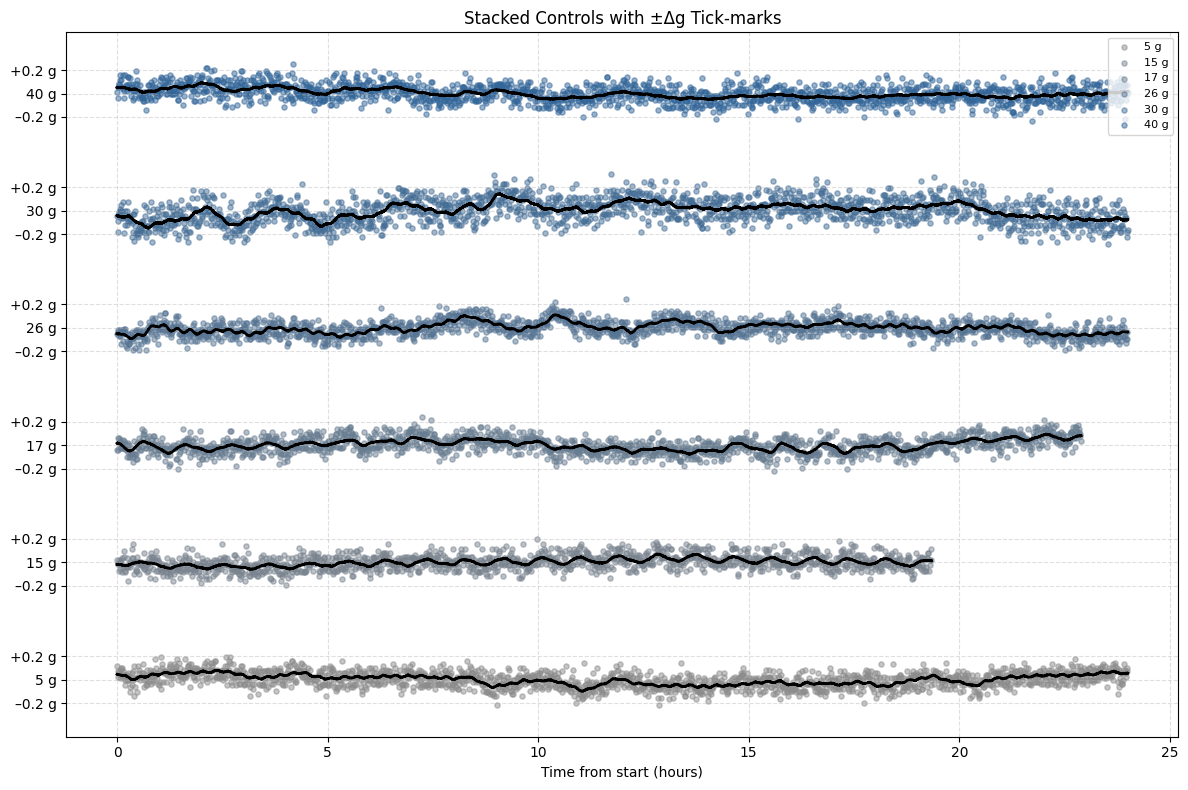

Saving figure to /Users/cohenlab/Desktop/bird_scale_experiment/figures/stacked_controls.svg
Figure saved successfully.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
# ─ user params ────────────────
control_bpath = Path.cwd() / "control_figure"
weights       = [5, 15, 17, 26, 30, 40]
hours_limit   = 24
# ──────────────────────────────
# build a 60%‐dark grey→blue map
grey_blue_60 = LinearSegmentedColormap.from_list(
    "grey_blue_60",
    ["#8C8C8C",  # ~45% grey
     "#336699"]  # a bit lighter navy-blue
)
colors = grey_blue_60(np.linspace(0, 1, len(weights)))

fig, ax = plt.subplots(figsize=(12, 8))
scale = 1.5
downsample_by = 40
# first: plot your stacked scatters & black smooths as before
for idx, w in enumerate(weights):
    df = pd.read_csv(control_bpath / f"d_control_{w}_weight_report.csv",
                     parse_dates=['Time'])
    df.rename(columns={df.columns[1]:'weight'}, inplace=True)

    df['t'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()/3600
    df = df[df['t'] <= hours_limit]
    df_down = df.iloc[::downsample_by]

    mu      = df['weight'].mean()
    y_sc    = (df_down['weight'] - mu)*scale + (idx+1)
    ax.scatter(df_down['t'], y_sc, color=colors[idx], alpha=0.5, s=14, label=f"{w} g")

    smooth  = df['weight'].rolling(500, center=True, min_periods=1).mean()
    y_ln    = (smooth - mu)*scale + (idx+1)
    ax.plot(df['t'], y_ln, color='k', lw=2)

# now: build custom y‐ticks (baseline ± delta)
yticks     = []
ytlabels   = []
for idx, w in enumerate(weights):
    # recompute std on full data (or reuse if you stored it)
    df = pd.read_csv(control_bpath / f"d_control_{w}_weight_report.csv",
                     parse_dates=['Time'])
    df.rename(columns={df.columns[1]:'weight'}, inplace=True)
    std_dev = df['weight'].std()

    # choose ±0.2 g if low‐variance, else ±0.25 g
    delta = 0.2 if std_dev < 0.2 else 0.25
    base  = idx+1

    yticks   += [base - delta, base, base + delta]
    ytlabels += [f"–{delta} g", f"{w} g", f"+{delta} g"]

# apply them all at once
ax.set_yticks(yticks)
ax.set_yticklabels(ytlabels)

ax.set_xlabel('Time from start (hours)')
ax.set_title('Stacked Controls with ±Δg Tick‐marks')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

# # save as svg file
# save_path = control_bpath.parent / "figures" /  "stacked_controls.svg"
# print(f"Saving figure to {save_path}")
# fig.savefig(save_path, format='svg', bbox_inches='tight', dpi=300)
# print("Figure saved successfully.")


# Part 2 - comparison


Control Weight Analysis Results:

File: 5
  Mode Weight: 5.01
  Actual Weight: 5
  Median Weight: 5.01
  Std Weight: 0.045314091797535566
  Num Records: 72156

File: 11
  Mode Weight: 11.21
  Actual Weight: 11.2
  Median Weight: 11.21
  Std Weight: 0.050512870473498624
  Num Records: 600

File: 15
  Mode Weight: 15.78
  Actual Weight: 15.75
  Median Weight: 15.78
  Std Weight: 0.04129731433185387
  Num Records: 58144

File: 17
  Mode Weight: 17.39
  Actual Weight: 17.3
  Median Weight: 17.38
  Std Weight: 0.04498175164617445
  Num Records: 68826

File: 26
  Mode Weight: 26.57
  Actual Weight: 26.8
  Median Weight: 26.57
  Std Weight: 0.043754262482896
  Num Records: 72153

File: 30_long
  Mode Weight: 29.9
  Actual Weight: 30
  Median Weight: 29.9
  Std Weight: 0.07635550117787976
  Num Records: 349245

File: 40_long
  Mode Weight: 40.56
  Actual Weight: 40.6
  Median Weight: 40.56
  Std Weight: 0.056889333655670504
  Num Records: 349245


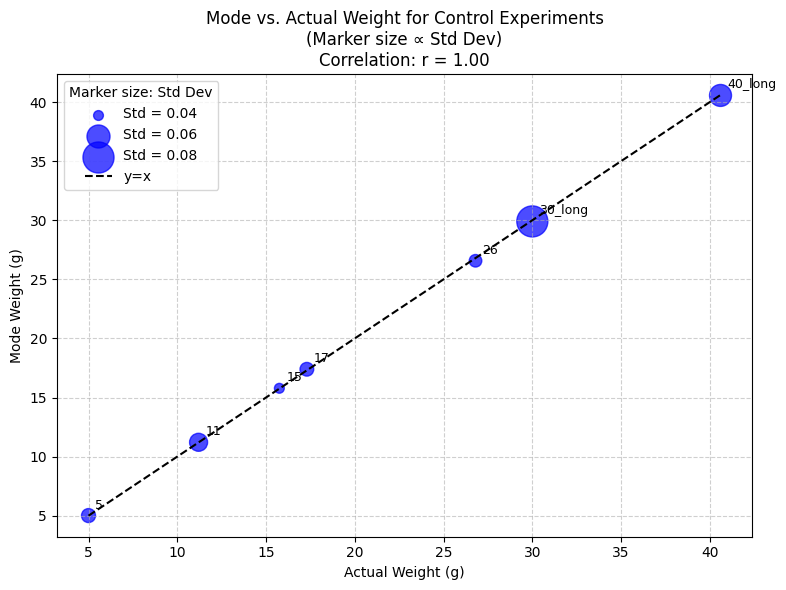

In [25]:
# read control weight analysis results:
import json
from pathlib import Path
import matplotlib.pyplot as plt
# Define the base path for control experiments
control_base_path = Path.cwd() / "control_exp"

# Load the control weight analysis results
control_results_path = control_base_path / "control_weight_analysis_results.json"
with open(control_results_path, 'r') as f:
    control_res = json.load(f)  

# Print the control results
print("Control Weight Analysis Results:")
for fname, metrics in control_res.items():
    print(f"\nFile: {fname}")
    print(f"  Mode Weight: {metrics.get('mode_weight', 'N/A')}")
    print(f"  Actual Weight: {metrics.get('actual_weight', 'N/A')}")
    print(f"  Median Weight: {metrics.get('median_weight', 'N/A')}")
    print(f"  Std Weight: {metrics.get('std_weight', 'N/A')}")
    print(f"  Num Records: {metrics.get('num_records', 'N/A')}")

# Plot mode vs. actual weight for each control
actual_weights = []
mode_weights = []
labels = []
std_weights = []

for fname, metrics in control_res.items():
    actual = metrics.get('actual_weight')
    mode = metrics.get('mode_weight')
    std = metrics.get('std_weight')
    if actual is not None and mode is not None and std is not None:
        actual_weights.append(actual)
        mode_weights.append(mode)
        labels.append(fname)
        std_weights.append(std)

# Normalize std_weights for marker size (optional: scale for better visibility)
if std_weights:
    min_size = 50
    max_size = 500
    std_arr = np.array(std_weights)
    # Avoid division by zero if all std are the same
    if std_arr.max() > std_arr.min():
        sizes = min_size + (std_arr - std_arr.min()) / (std_arr.max() - std_arr.min()) * (max_size - min_size)
    else:
        sizes = np.full_like(std_arr, (min_size + max_size) / 2)
else:
    sizes = 100

plt.figure(figsize=(8, 6))
scatter = plt.scatter(actual_weights, mode_weights, s=sizes, color='blue', alpha=0.7)
for i, label in enumerate(labels):
    plt.annotate(label, (actual_weights[i], mode_weights[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)
plt.plot([min(actual_weights), max(actual_weights)], [min(actual_weights), max(actual_weights)], 'k--', label='y=x')
plt.xlabel('Actual Weight (g)')
plt.ylabel('Mode Weight (g)')

# Calculate and display correlation coefficient
if len(actual_weights) > 1:
    corr_coef = np.corrcoef(actual_weights, mode_weights)[0, 1]
    plt.title(f'Mode vs. Actual Weight for Control Experiments\n(Marker size ∝ Std Dev)\nCorrelation: r = {corr_coef:.2f}')
else:
    plt.title('Mode vs. Actual Weight for Control Experiments\n(Marker size ∝ Std Dev)')

# Add a legend for marker size (std dev)
import matplotlib.lines as mlines
import numpy as np
if std_weights:
    # Pick 3 representative std values for legend
    std_legend_vals = np.linspace(np.min(std_weights), np.max(std_weights), 3)
    size_legend_vals = min_size + (std_legend_vals - np.min(std_weights)) / (np.max(std_weights) - np.min(std_weights)) * (max_size - min_size) if np.max(std_weights) > np.min(std_weights) else np.full_like(std_legend_vals, (min_size + max_size) / 2)
    handles = [
        plt.scatter([], [], s=size, color='blue', alpha=0.7, label=f"Std = {std:.2f}")
        for std, size in zip(std_legend_vals, size_legend_vals)
    ]
    plt.legend(handles=handles + [mlines.Line2D([], [], color='k', linestyle='--', label='y=x')],
               title="Marker size: Std Dev", loc='best')
else:
    plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()


# fig_save_name = Path('figures/control_comparison.svg')
# plt.savefig(fig_save_name, bbox_inches='tight', dpi=300, format='svg')

plt.show()


# Part 3 - view and edit raw data

In [28]:
from pipeline import read_timeseries
# Read control weight reports
base_path = Path.cwd()
control_bpath = base_path / "control_exp" 
current_fname = '5'
current_path = control_bpath / f"control_{current_fname}_weight_report.csv"
print(current_path)
low_thrd = 0
high_thrd = 100
start_date = '2025-06-06'          # e.g., '2025-06-11'
end_date = '2025-06-07'           # e.g., '2025-06-19'
start_time = None          # e.g., '12:00'
end_time = None

# Load the CSV data
control_data = read_timeseries(file_path=current_path, low_thrd=low_thrd, high_thrd=high_thrd, start_date=start_date, end_date=end_date)
print(control_data.shape)

# save to csv with same filename   
control_data.to_csv(current_path, index=False)

# save to csv with new filename
# save_path = base_path / "control_figure"
# os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist
# new_name = "40"
# save_path = save_path / f"d_control_{new_name}_weight_report.csv"
# print(save_path)
# control_data.to_csv(save_path, index=False)

/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_5_weight_report.csv
(72156, 2)


--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_15_weight_report.csv' ---
Shape: (58144, 2)
Date range: 2024-09-29 16:20:30 → 2024-09-30 11:40:59
Weight range: 15.61g → 15.94g

Basic statistics:
 count    58144.000000
mean        15.776766
std          0.041297
min         15.610000
25%         15.750000
50%         15.780000
75%         15.800000
max         15.940000
Name: weight, dtype: float64


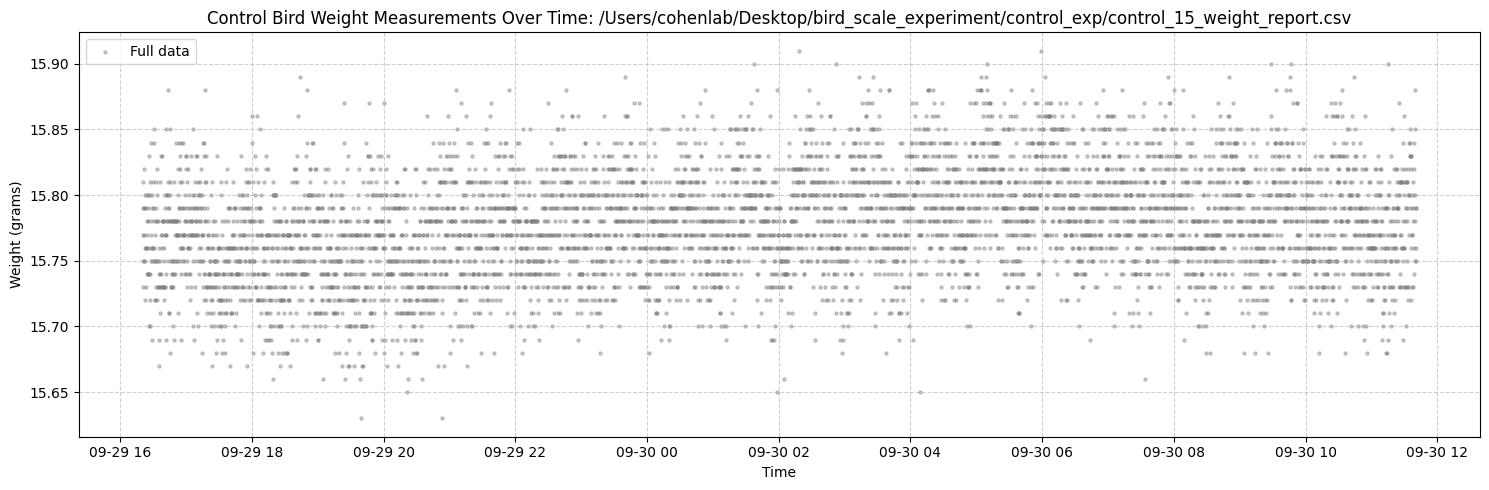

--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_11_weight_report.csv' ---
Shape: (600, 2)
Date range: 2025-06-09 16:44:06 → 2025-06-09 16:56:17
Weight range: 10.96g → 11.38g

Basic statistics:
 count    600.000000
mean      11.207950
std        0.050513
min       10.960000
25%       11.180000
50%       11.210000
75%       11.240000
max       11.380000
Name: weight, dtype: float64


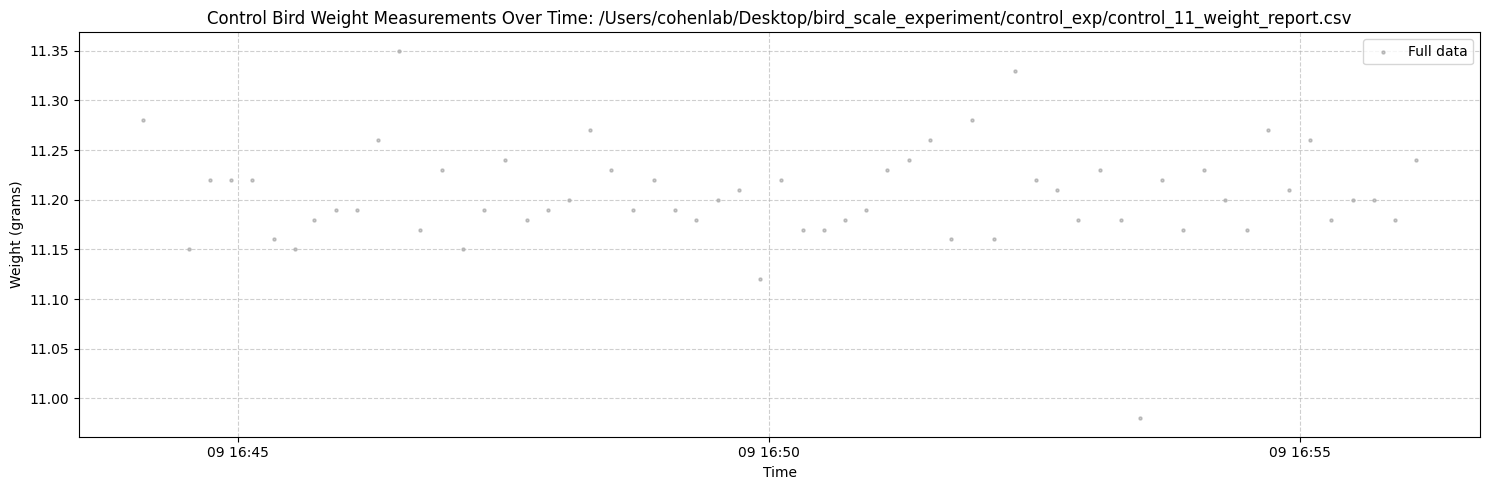

--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_26_weight_report.csv' ---
Shape: (72153, 2)
Date range: 2025-06-08 00:00:01 → 2025-06-09 00:00:00
Weight range: 25.90g → 26.84g

Basic statistics:
 count    72153.000000
mean        26.574081
std          0.043754
min         25.900000
25%         26.540000
50%         26.570000
75%         26.600000
max         26.840000
Name: weight, dtype: float64


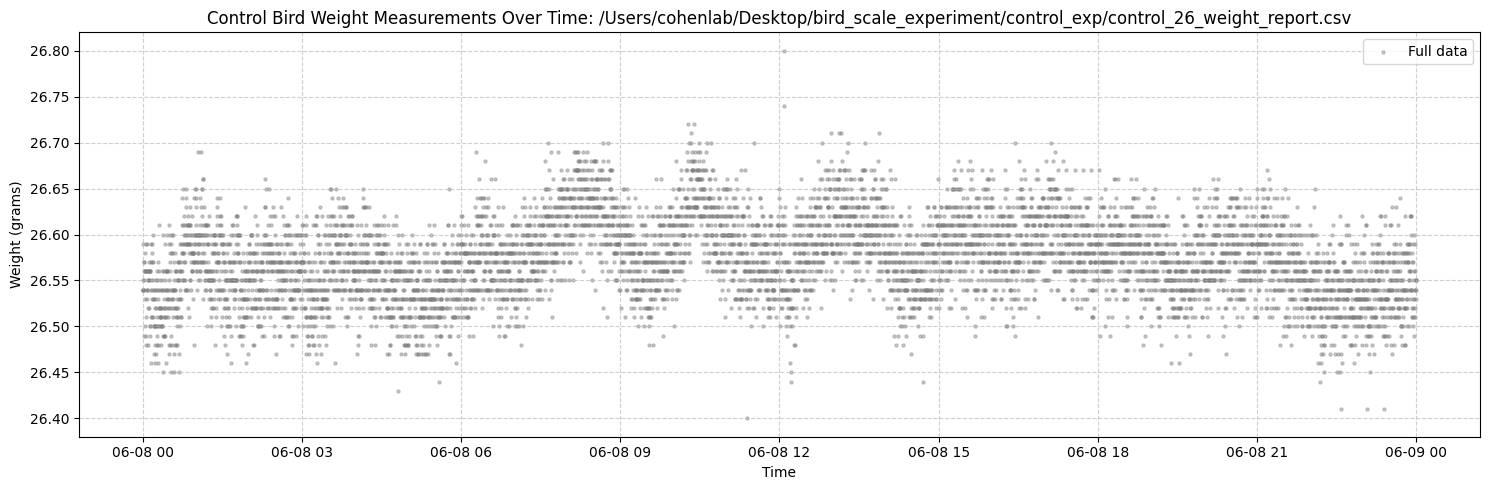

--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_5_weight_report.csv' ---
Shape: (72156, 2)
Date range: 2025-06-06 00:00:01 → 2025-06-07 00:00:00
Weight range: 4.72g → 5.27g

Basic statistics:
 count    72156.000000
mean         5.012909
std          0.045314
min          4.720000
25%          4.980000
50%          5.010000
75%          5.040000
max          5.270000
Name: weight, dtype: float64


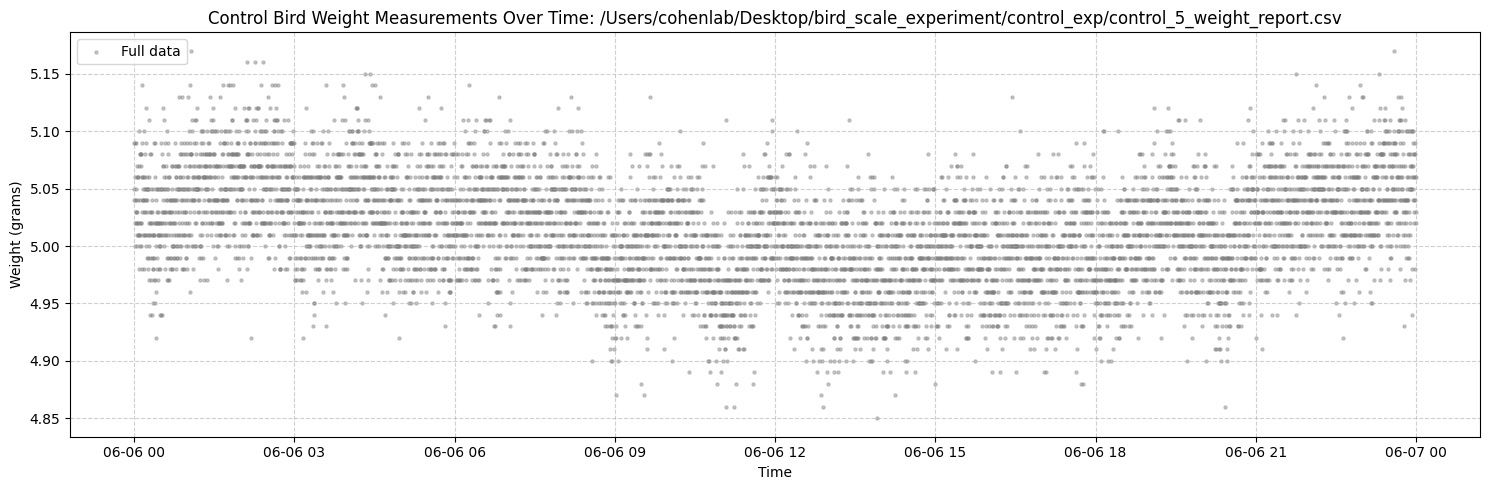

--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_17_weight_report.csv' ---
Shape: (68826, 2)
Date range: 2024-09-25 10:39:18 → 2024-09-26 09:32:59
Weight range: 17.20g → 17.57g

Basic statistics:
 count    68826.000000
mean        17.377987
std          0.044982
min         17.200000
25%         17.350000
50%         17.380000
75%         17.410000
max         17.570000
Name: weight, dtype: float64


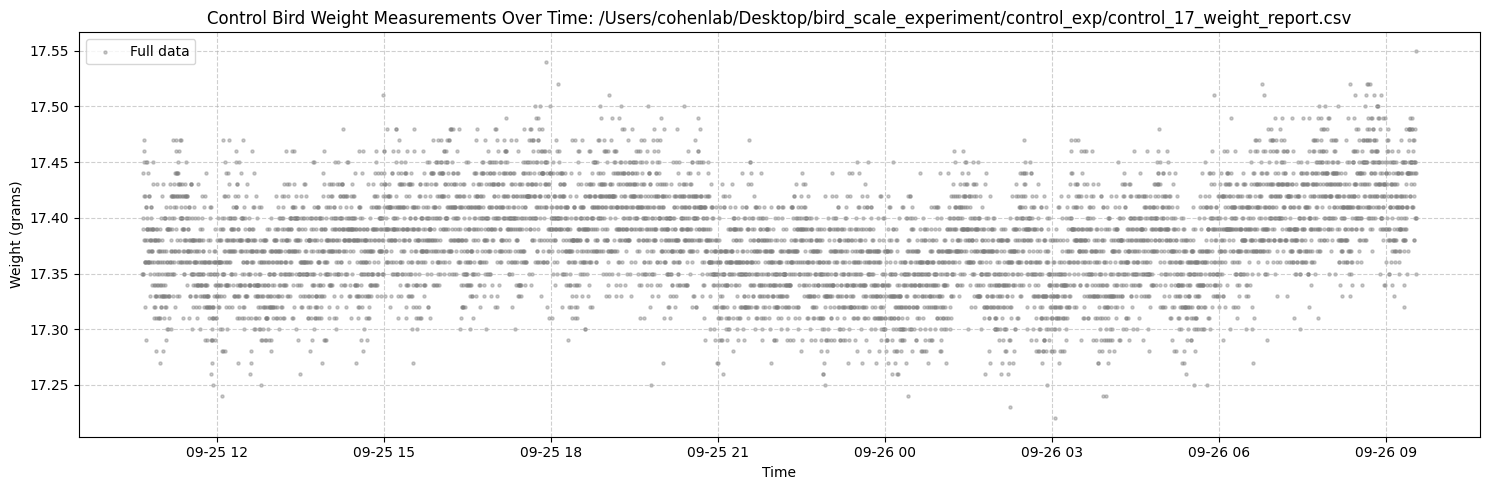

--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_30_long_weight_report.csv' ---
Shape: (349246, 2)
Date range: 2025-07-16 14:28:43 → 2025-07-21 10:39:16
Weight range: 29.47g → 30.36g

Basic statistics:
 count    349245.000000
mean         29.902957
std           0.076356
min          29.470000
25%          29.850000
50%          29.900000
75%          29.950000
max          30.360000
Name: weight, dtype: float64


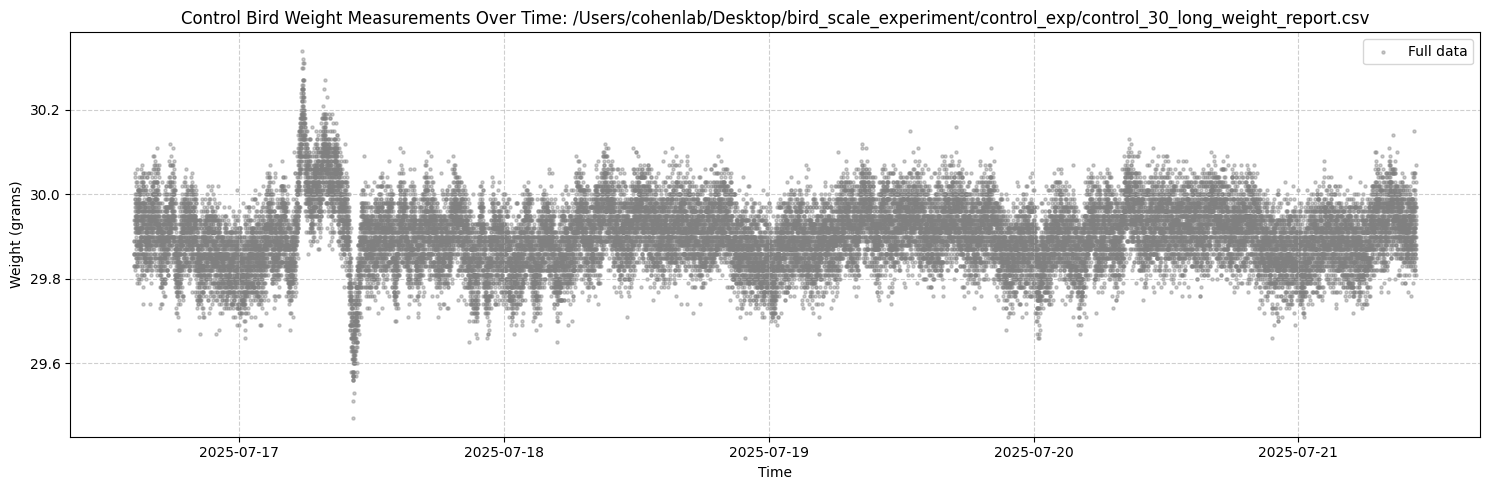

--- Dataset for control bird '/Users/cohenlab/Desktop/bird_scale_experiment/control_exp/control_40_long_weight_report.csv' ---
Shape: (349246, 2)
Date range: 2025-07-16 14:28:43 → 2025-07-21 10:39:16
Weight range: 40.23g → 40.84g

Basic statistics:
 count    349245.000000
mean         40.556527
std           0.056889
min          40.230000
25%          40.520000
50%          40.560000
75%          40.590000
max          40.840000
Name: weight, dtype: float64


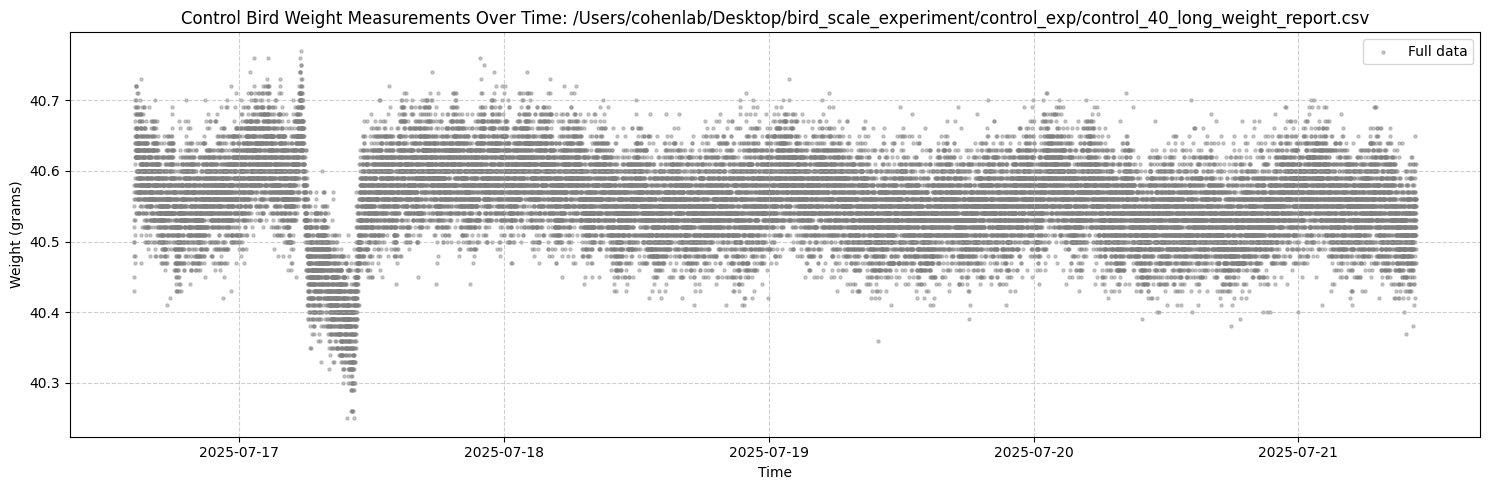

In [ ]:
import glob
# Read control weight reports
base_path = Path.cwd()
control_bpath = base_path / "control_exp" 
# Define the filenames to read - read from control_bpath using glob
fnames = glob.glob(str(control_bpath / "control_*.csv"))
# fnames = ['5_long', '5_new', '5', '11_2', '26_8', '30_long', '40_long']
for current_fname in fnames:
    # current_path = control_bpath / f"control_{current_fname}_weight_report.csv"
    # Load the CSV data
    control_data = pd.read_csv(current_fname)
    # Convert Time column to datetime
    control_data['Time'] = pd.to_datetime(control_data['Time'])
    if 'weight' not in control_data.columns:
        control_data.rename(columns={control_data.columns[1]: 'weight'}, inplace=True)

    #print description of the data
    print(f"--- Dataset for control bird '{current_fname}' ---")
    print(f"Shape: {control_data.shape}")
    print(f"Date range: {control_data['Time'].min()} → {control_data['Time'].max()}")
    print(f"Weight range: {control_data['weight'].min():.2f}g → {control_data['weight'].max():.2f}g")
    print("\nBasic statistics:\n", control_data['weight'].describe())
    # Plot the full data
    plt.figure(figsize=(15,5))
    plt.scatter(control_data['Time'][::10], control_data['weight'][::10], color='gray', alpha=0.4, label='Full data', s=5)

    plt.xlabel('Time')
    plt.ylabel('Weight (grams)')
    plt.title(f'Control Bird Weight Measurements Over Time: {current_fname}')
    plt.legend()
    # Improve layout and grid
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    # Show plot
    plt.show()